In [4]:
#pip install lightgbm

In [5]:
# import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import LabelBinarizer, label_binarize
from sklearn.preprocessing import LabelEncoder, RobustScaler
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import make_classification
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve

In [6]:
# Load the dataset
file_path = "./UAVNet-Defense Comprehensive UAV Network Traffic Dataset.csv"
df = pd.read_csv(file_path)

In [7]:
# Encode 'Protocol' and 'label'
protocol_encoder = LabelEncoder()
df["Protocol"] = protocol_encoder.fit_transform(df["Protocol"])

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])
print("\nLabel Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))


Label Mapping: {'AODV Attack': 0, 'Flooding Attack': 1, 'Legitimate AODV Traffic': 2, 'Normal Traffic': 3, 'Sybil Attack': 4}


In [8]:
# Define feature columns and label column
feature_columns = [
    "FlowDuration/s", "SrcPort", "DstPort", "Protocol",
    "TxPackets", "RxPackets", "LostPackets", "TxBytes", "RxBytes",
    "TxPacketRate/s", "RxPacketRate/s", "TxByteRate/s", "RxByteRate/s",
    "MeanDelay/s", "MeanJitter/s", "Throughput/Kbps",
    "MeanPacketSize", "PacketDropRate", "AverageHopCount"
]
label_column = "label"

In [9]:
scaler = RobustScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

In [10]:
# Prepare the data
X = df[feature_columns].values
y = to_categorical(df[label_column])
n_classes = y.shape[1]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
print("\nTraining Set Label Distribution:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Testing Set Label Distribution:", dict(zip(*np.unique(y_test, return_counts=True))))


Training Set Label Distribution: {0.0: 136944, 1.0: 34236}
Testing Set Label Distribution: {0.0: 34236, 1.0: 8559}


In [13]:
y_train_labels = np.argmax(y_train, axis=1).astype(np.int32)
y_test_labels = np.argmax(y_test, axis=1).astype(np.int32)

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train_labels)
test_data = lgb.Dataset(X_test, label=y_test_labels, reference=train_data)

In [14]:
print("y_train_labels shape:", y_train_labels.shape)
print("y_test_labels shape:", y_test_labels.shape)

y_train_labels shape: (34236,)
y_test_labels shape: (8559,)


In [15]:
# Define LightGBM parameters
params = {
    'objective': 'multiclass',
    'num_class': n_classes,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

In [16]:
# Train the LightGBM model
lgb_model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=200)


In [17]:
y_pred_prob = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# Evaluation Metrics
print("\nAccuracy:", accuracy_score(y_test_labels, y_pred_labels))
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))


Accuracy: 0.9657670288585115

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      1767
           1       1.00      0.97      0.99       194
           2       0.97      0.97      0.97      5135
           3       0.99      1.00      0.99      1189
           4       0.98      0.97      0.97       274

    accuracy                           0.97      8559
   macro avg       0.97      0.97      0.97      8559
weighted avg       0.97      0.97      0.97      8559



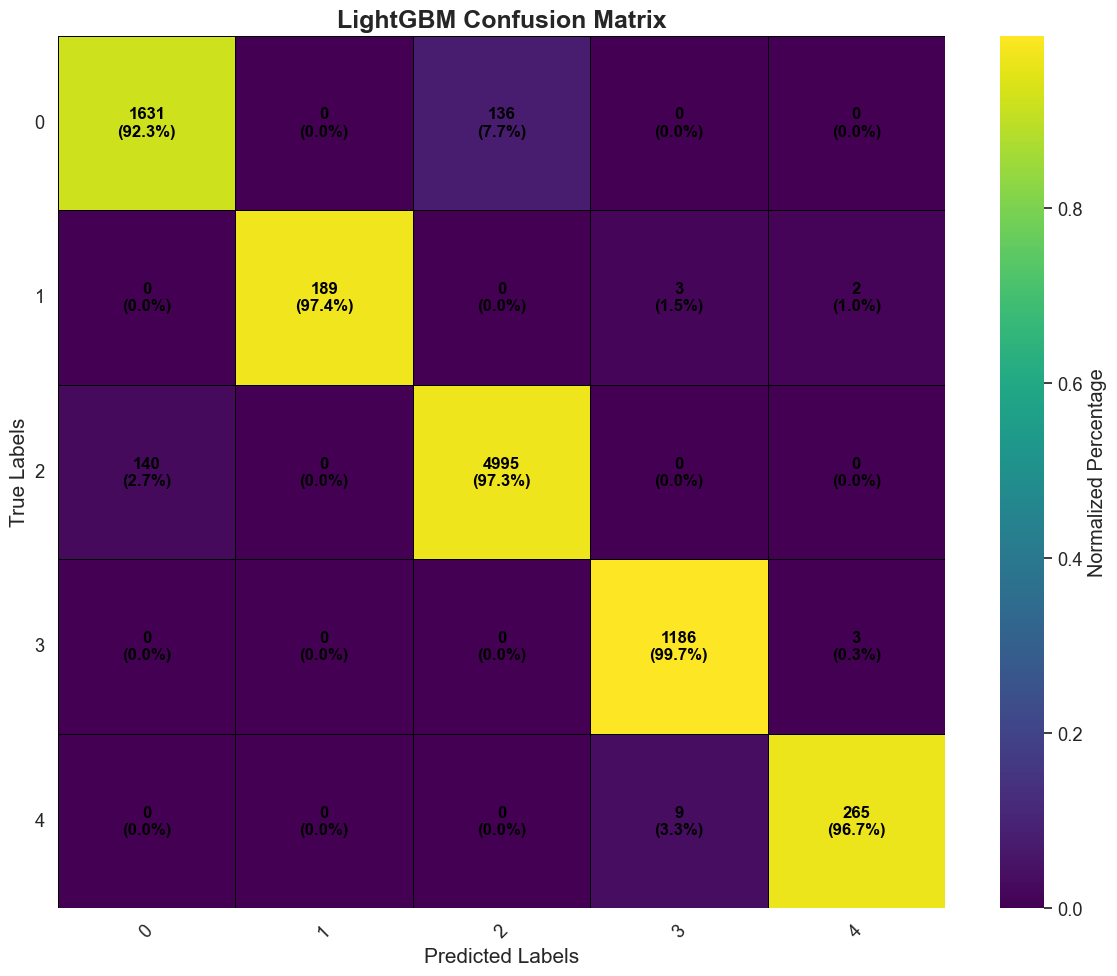

In [18]:
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Normalize the confusion matrix by true labels (rows)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create the figure
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.2)
cmap = sns.color_palette("viridis", as_cmap=True)

# Plot the heatmap with both counts and normalized percentages
heatmap = sns.heatmap(conf_matrix_normalized, annot=False, cmap=cmap, xticklabels=range(n_classes), yticklabels=range(n_classes), linewidths=0.5, linecolor='black', cbar_kws={'label': 'Normalized Percentage'})

# Annotate each cell with the raw count and normalized percentage
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        count = conf_matrix[i, j]
        percentage = conf_matrix_normalized[i, j] * 100
        text = f"{count}\n({percentage:.1f}%)"
        heatmap.text(j + 0.5, i + 0.5, text, ha='center', va='center', color="black", fontsize=12, fontweight='bold')

# Set titles, labels, and formatting
plt.title("LightGBM Confusion Matrix", fontsize=18, fontweight='bold')
plt.xlabel("Predicted Labels", fontsize=15)
plt.ylabel("True Labels", fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot to a file
plt.savefig("lightgbm_confusion_matrix.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

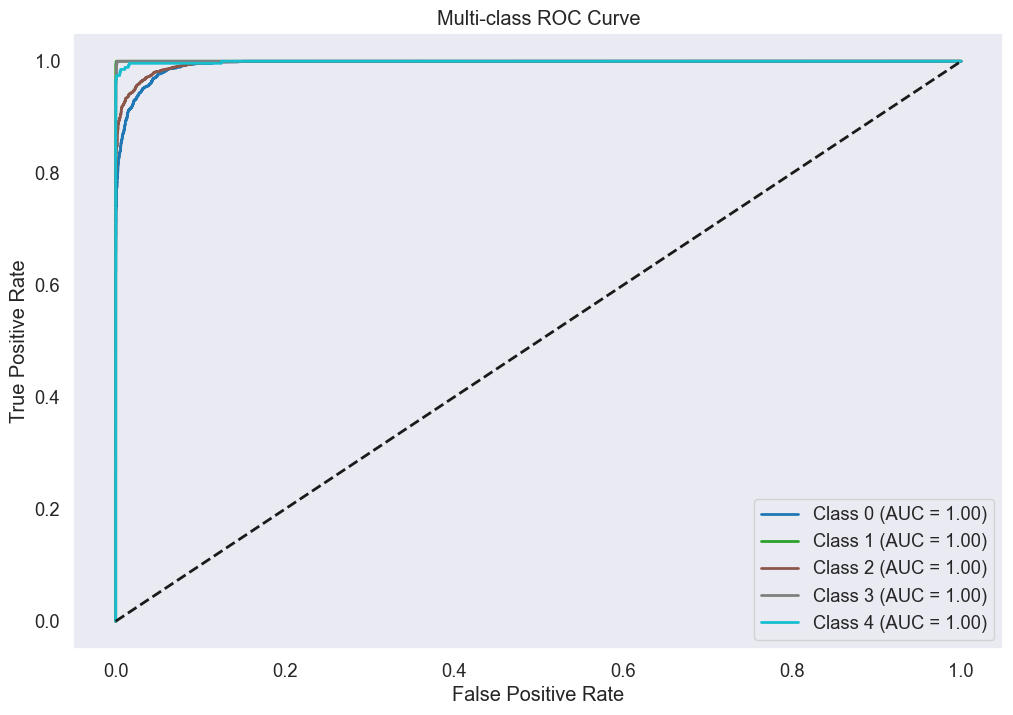

In [19]:
# Multi-class ROC Curve
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, n_classes))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, color=colors[i], label=f"Class {i} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title("Multi-class ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

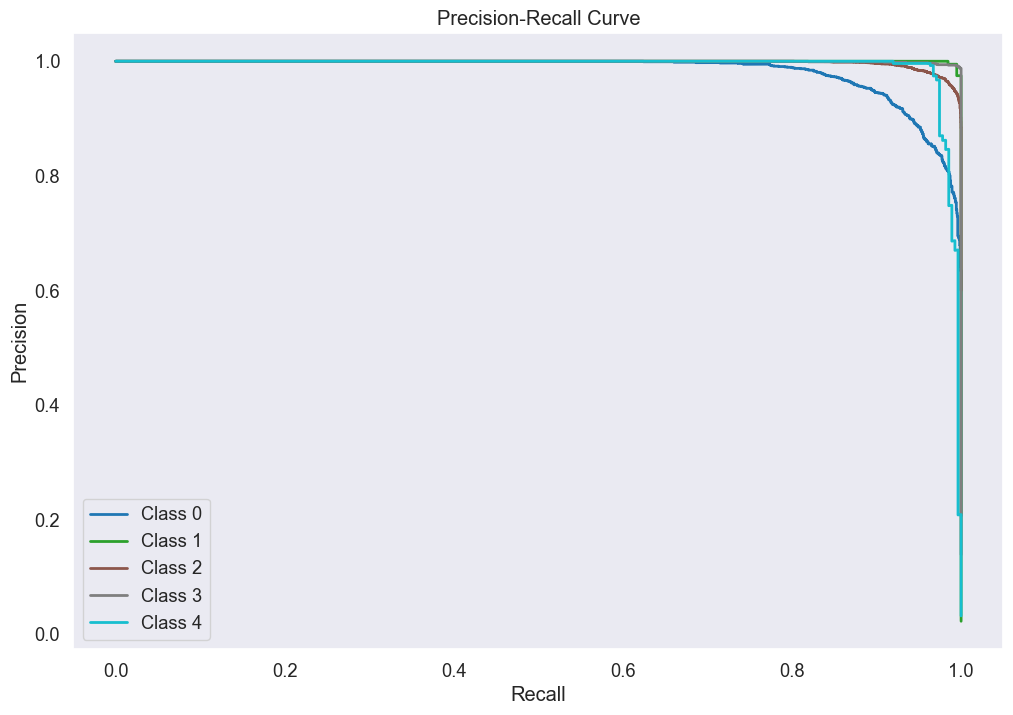

In [20]:
# Precision-Recall Curve
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, lw=2, color=colors[i], label=f"Class {i}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()
plt.show()

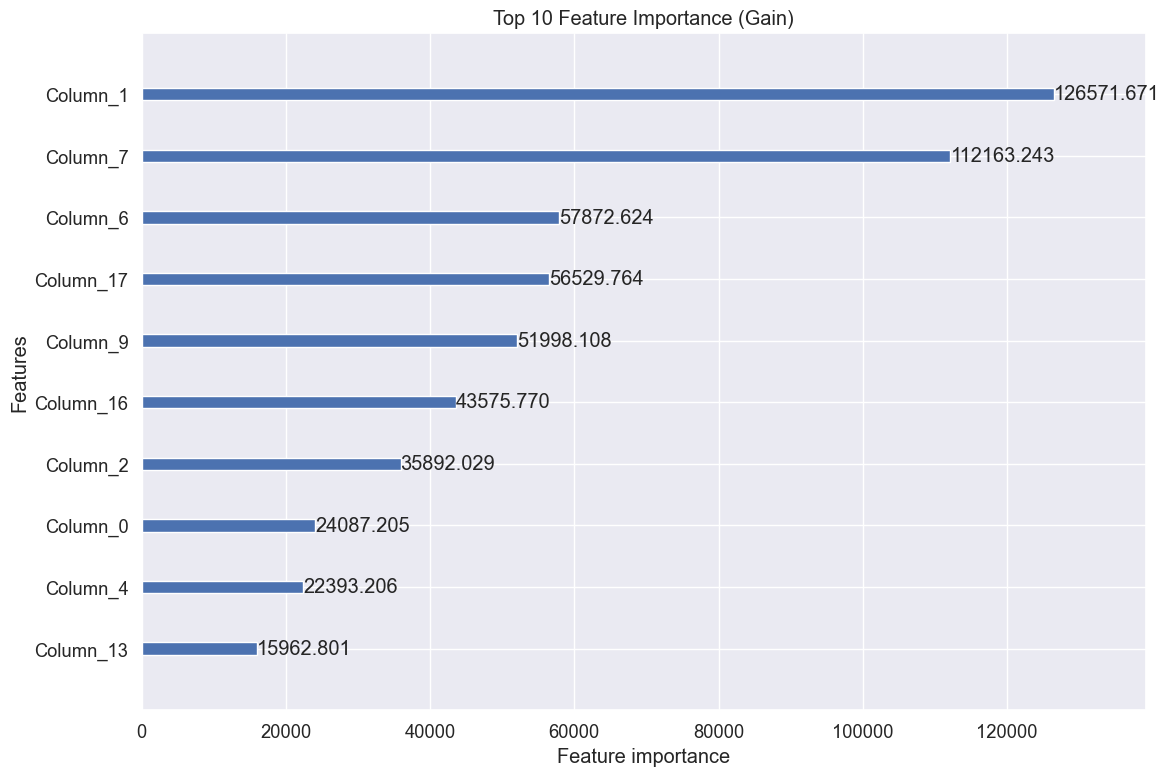

In [31]:
# Feature Importance Plot
lgb.plot_importance(lgb_model, max_num_features=10, importance_type='gain', figsize=(12, 8))
plt.title("Top 10 Feature Importance (Gain)")
plt.tight_layout()
plt.savefig("top_10_feature_importance_gain.png", dpi=300, bbox_inches='tight')
plt.show()